# Financial US Stocks data reports classification 
    
   
# Marcos Barragán & Adrián González 
    
# Machine Learning
    
### Final Practice
    
### 15/01/2021
    
__CUNEF__

# Class Variation classifications:

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import pickle
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
import scikitplot as skplt
from sklearn.metrics import plot_confusion_matrix
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

For this model, it is necessary to drop out `Price Variation Company vs. Sector`, `PRICE_VAR[%]` and `Class`, because they are related to the target we are considering.

In [2]:
data_train = pd.read_excel("../data/data_train.xlsx", index_col = 0)
data_test = pd.read_excel("../data/data_test.xlsx", index_col = 0)

In [7]:
data_train.drop(['Price Variation Company vs. Sector', 'PRICE_VAR[%]', 'Class'], axis=1, inplace=True)
data_test.drop(['Price Variation Company vs. Sector', 'PRICE_VAR[%]', 'Class'], axis=1, inplace=True)

In [9]:
data_train['Price_var_vs_sector'] = data_train['Price_var_vs_sector'].astype('object')
data_test['Price_var_vs_sector'] = data_test['Price_var_vs_sector'].astype('object')

### Including Pipelines to process our data:

Pipeline will be used to scale our variables but, moreover, it will be used as well to remove NA values applying K-Nearest Neighbours techniques. We will consider euclidean method and weights based on their distance to the 20 nearest neighbours.

In [10]:
numeric_transformer = Pipeline(steps=[
                                      ('imputer', 
                                       KNNImputer(n_neighbors=20, 
                                                  weights='distance', 
                                                  metric='nan_euclidean', 
                                                  copy=True)),
    
                                      ('scaler', StandardScaler())
                                    ])

In [11]:
numeric_features = data_train.select_dtypes(include=['int64', 'float64','int32']).columns

In [12]:
preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

In [13]:
pl2 = '../pipelines/pipeline_var.sav'

pickle.dump(preprocessor1, open(pl2, 'wb'))

### Train and test definition:

We need to reconsider y train and test as numeric feature once the Pipeline has been applied.

In [14]:
xtrain = data_train.drop('Price_var_vs_sector', axis=1)

ytrain = data_train['Price_var_vs_sector']
ytrain = ytrain.astype('int64')

In [15]:
xtest = data_test.drop('Price_var_vs_sector', axis=1)

ytest = data_test['Price_var_vs_sector']
ytest = ytest.astype('int64')

In [16]:
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((17685, 33), (17685,), (4392, 33), (4392,))

## Gaussian Naive-Bayes Models:

Gaussian NB is codified in Python as GaussianNB(). 

First of all, we need to load our pipeline and apply it to data:

In [17]:
# Cargamos el Pipeline
pl2 = '../pipelines/pipeline_var.sav'
pickle.dump(preprocessor1, open(pl2, 'wb'))

In [143]:
gnb = Pipeline(steps=[
                       ('preprocesado', preprocessor1),
                       ('clasificador', GaussianNB())])
gnb.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesado',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=20,
                                                                              weights='distance')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Revenue Growth', 'Cost of Revenue', 'EPS', 'Dividend per Share',
       'Gross Margin', 'EBITDA Margin', 'Free Cash Flow margin', 'Receivables',
       'Inventories', 'Total assets', 'Total current liabil...
       'returnOnEquity', 'debtEquityRatio', 'freeCashFlowPerShare',
       'Net Income per Share', 'Net Debt to EBITDA', 'Current ratio', 'ROIC',
       'Enterprise Value over EBITDA', 'EBITDA Margin Company

+ ### GNB Scores:

The results this model shows out for this variable may seem really poor. But later, when developing ROC and confusion matrices we will see they are not so bad as they seem to be.

In [144]:
gnb.score(xtrain, ytrain)

0.3982794479107582

In [145]:
gnb.score(xtest, ytest)

0.37545537340619306

+ ### GNB Predictions and Probabilities:

In [146]:
y_pred = gnb.predict(xtest)

In [147]:
y_prob = gnb.predict_proba(xtest)

+ ### ROC GNB model:

In [148]:
def roc(model, title):
    
    skplt.metrics.plot_roc(ytest, y_prob) # un roc con todas las metricas
    plt.title(f"ROCs curve for {title}.");

We see that the ROCs curves for our model are pretty good. The AUC we get back are:

+ 71% for class-0 classifiers,


+ 60% for class-1 classifiers,


+ 47% for class-2 classifiers.

We achieve good values for class-0 and class-1 classifiers, but when it comes to class-2 PV companies classification, it does not behave as we would like it to act. 

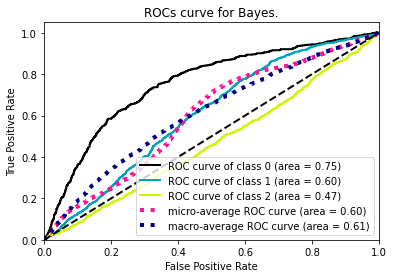

In [149]:
roc(gnb, 'Bayes')

+ ### Some classification reports:

In [150]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.34      0.50      0.41       604
           1       0.63      0.27      0.38      2496
           2       0.28      0.52      0.36      1292

    accuracy                           0.38      4392
   macro avg       0.42      0.43      0.38      4392
weighted avg       0.48      0.38      0.38      4392



+ ### Confusion Matrices:

The confusion matrix we are developing here shows out:

+ Class 0 companies are hit about 50% of times. The problem is that they are most commonly missclassified as class-2 PV companies.

+ Class 1 companies are dreadfully classificated, because the model predict class-2 values most of the times for true class-1 values.

+ Class 2 companies are the best classified for this model; more than a half times it predicts class-2 correctly, and misclassifications are balanced between class-0 and class-1 values.


This problem may come out because (as we said in the EDA notebook) 2018 Price-Variation data do not behave as 2014-2017 ones. Due to this problem of unbalanced test data compared to train data, we might have achieved poorer results in comparision with those achieved in the other target variables.

Nevermind, we tried to rebalance data in order to achieve the same class-levels as in test data. The result obtained was that the model not only did not increased its accuracy, but got it even poreer.

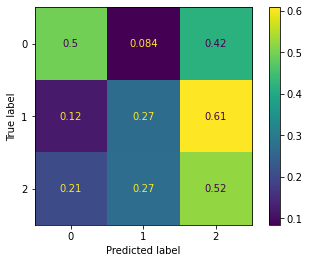

In [151]:
plot_confusion_matrix(gnb, xtest, y_true=ytest, normalize='true');

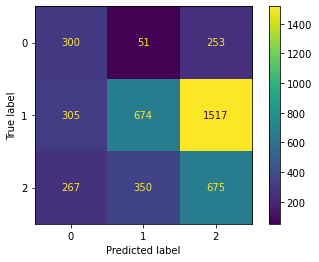

In [152]:
plot_confusion_matrix(gnb, X=xtest, y_true=ytest);

The results are not good enough as we expected them to be. But thinking it deeply, this is understandable, because we are treating to predict companies' price variations over a financial period compared to its sector. 

This is a really ambitious target, because price variation is not as predictable as dividend or class target could be. Moreover, price variation is a really volatile and inconstant variable, so it is not so easy to predict whether a company is going to increase or decrease its stock values and classificate them. (If that was posible, everybody would earn money in stock markets).

+ ### ROC curve with optimal point:

If we plot out the ROC curve and explicitly highlight the best score for that ROC, we will be obtaining the metric that appears in the accuracy part.

In [168]:
probabilidad_po1 = y_prob[:, 1]

In [169]:
probabilidad_po2 = y_prob[:, 0]

In [170]:
falsos_po, verdaderos_po, intervalos = roc_curve(ytest, 
                                                 probabilidad_po, 
                                                 pos_label=1)

In [171]:
falsos_po2, verdaderos_po2, intervalos2 = roc_curve(ytest, 
                                                     probabilidad_po2, 
                                                     pos_label=2)

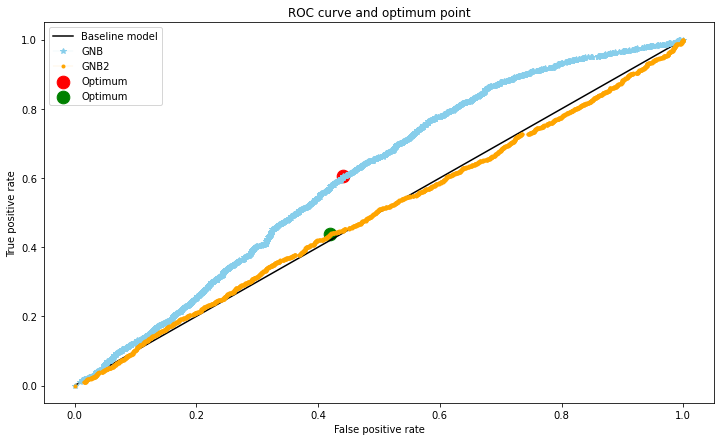

In [172]:
media = np.sqrt(verdaderos_po * (1-falsos_po))
maximo_g = np.argmax(media)

media2 = np.sqrt(verdaderos_po2 * (1-falsos_po2))
maximo_g2 = np.argmax(media2)

plt.figure(figsize=(12, 7))


plt.plot([0,1], [0,1], 
         color='black',
         label='Baseline model') 


plt.plot(falsos_po,
         verdaderos_po, 
         marker='*',
         linewidth=0.1,
         color='skyblue',
         label='GNB')

plt.plot(falsos_po2,
         verdaderos_po2, 
         marker='.',
         linewidth=0.1,
         color='orange',
         label='GNB2')

plt.scatter(falsos_po[maximo_g], 
            verdaderos_po[maximo_g], 
            s=160, 
            marker='o', 
            color='red', 
            label='Optimum')
         
plt.scatter(falsos_po2[maximo_g2], 
            verdaderos_po2[maximo_g2], 
            s=160, 
            marker='o', 
            color='green', 
            label='Optimum')


plt.title('ROC curve and optimum point')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend();

GNB1 curve represents class-1 price variation and GNB2 are class-0 price variation companies. We see that for GNB2, we get a 50-50 ratio of TPR over FPR, and for GNB1 it is a little better, because we achieve a 60% of TPR for less than 50% of FPR.

## Bibliography:

+ https://medium.com/@douglaspsteen/precision-recall-curves-d32e5b290248


+ https://stripe.com/docs/api/balance?lang=python


+ https://nilimeshhalder.medium.com/multiclass-classification-using-naïve-bayes-classifiers-in-python-an-applied-machine-learning-afe38951daa4


+ https://towardsdatascience.com/tuning-parameters-heres-how-39a4d1956f79